## Time-Series Forecasting
* A time-series data having the mean and variance as a constant is called a **stationary time series**.
* Time series tend to have a linear relationship between lagged variables and this is called an **autocorrelation**.

### Components of Time Series


* **Trend** – A long-term increase or decrease are termed trends.
* **Seasonality** An effect of seasonal factors for a fixed or known period. For example, retail stores sales will be high during weekends and festival seasons.
* **Cycle** – These are the longer ups and downs that are not of fixed or known periods caused by external factors.

### Autoregressive Integrated Moving Average (ARIMA)
* **Autoregressive Model (AM)**: As the name indicates, it is a regression of the variable against itself , that is, the linear combination of past values of the variables are used to forecast the future value.
* **Moving average (MA)**: Instead of past values, a past forecast’s errors are used to build a model.

The predictors on the right side of the equation are the lagged values, errors, and it is also known as **ARIMA (p, d, q)** model.

* p = order of the autoregressive part. That is the number of unknown terms that multiply your signal at past times (so many past times as your value p).
* d = degree of first differencing involved. Number of times you have to difference your time series to have a stationary one.
* q = order of the moving average part. That is the number of unknown terms that multiply your forecast errors at past times (so many past times as your value q). See Listing

### Decompose time series
Data Source: O.D. Anderson (1976), in file: data/anderson14, Description:
Monthly sales of company X Jan ’65 – May ’71 C. Cahtfield

In [5]:
import pandas as pd

df = pd.read_csv('TS.csv')
df.head()

,Month,Sales
0,1965-01,154
1,1965-02,96
2,1965-03,73
3,1965-04,49
4,1965-05,36


In [38]:
ts = pd.Series(list(df['Sales']), index=pd.to_datetime(df['Month'],format='%Y-%m'))

<AxesSubplot:xlabel='Month'>

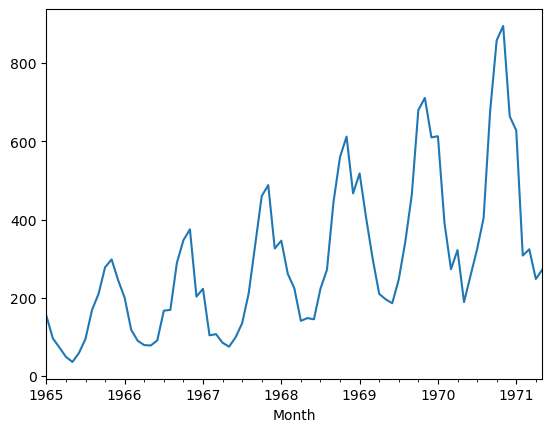

In [39]:
import matplotlib.pyplot as plt

ts.plot(x='Month',y='Sales')

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, model='multiplicative')

In [42]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

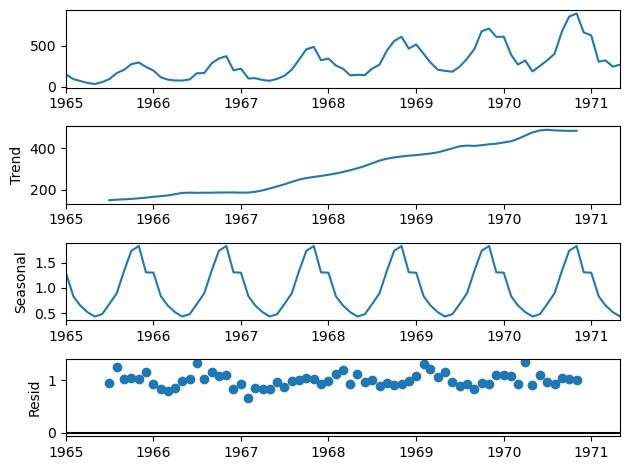

In [44]:
decomposition.plot()
plt.show()

### Checking for Stationary
Dickey Fuller test can be used to assess the
stationarity of series. Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC)

In [50]:
# log transform
import numpy as np

ts_log = np.log(ts)
ts_log.dropna(inplace=True)

In [65]:
ts_log

Month
1965-01-01    5.036953
1965-02-01    4.564348
1965-03-01    4.290459
1965-04-01    3.891820
1965-05-01    3.583519
                ...   
1971-01-01    6.442540
1971-02-01    5.730100
1971-03-01    5.780744
1971-04-01    5.513429
1971-05-01    5.605802
Length: 77, dtype: float64

In [53]:
# Dickey Fuller test
from statsmodels.tsa.stattools import adfuller

s_test = adfuller(ts_log, autolag='AIC')
print("Log transform stationary check p value: ", s_test[1])

Log transform stationary check p value:  0.78531021248491


In [59]:
#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)

Text(0, 0.5, 'First order log diff')

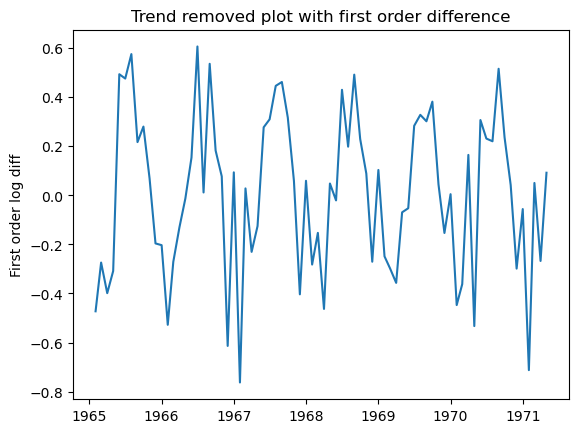

In [58]:
plt.title('Trend removed plot with first order difference')
plt.plot(ts_log_diff)
plt.ylabel('First order log diff')

In [61]:
s = adfuller(ts_log_diff, autolag='AIC')
print("First order difference stationary check p value: ", s[1])

First order difference stationary check p value:  0.02402539283987578


In [62]:
ts_log.shift()

Month
1965-01-01         NaN
1965-02-01    5.036953
1965-03-01    4.564348
1965-04-01    4.290459
1965-05-01    3.891820
                ...   
1971-01-01    6.498282
1971-02-01    6.442540
1971-03-01    5.730100
1971-04-01    5.780744
1971-05-01    5.513429
Length: 77, dtype: float64

### Autocorrelation Test
We determined that the log of time series requires at least one order differencing to stationarize. Now let’s plot ACV (Autocovarriance) and PACF charts for a first-order log series.

/home/user/.conda/envs/new_env/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


Text(0.5, 0, 'Lags')

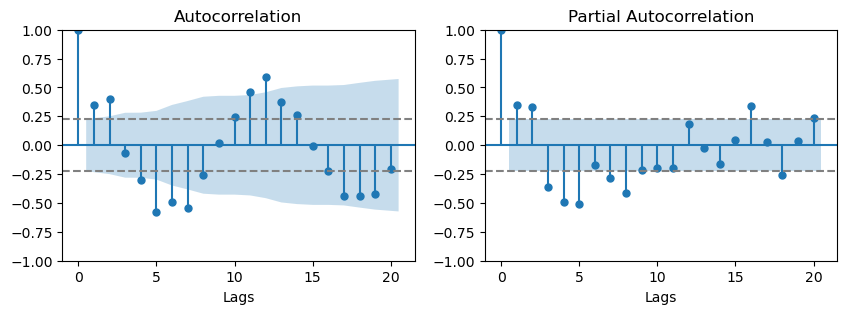

In [71]:
import statsmodels.api as sm

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,3))

# ACF chart
fig = sm.graphics.tsa.plot_acf(ts_log_diff.values.squeeze(), lags=20, ax=ax1)

# draw 95% confidence interval line
ax1.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax1.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax1.set_xlabel('Lags')

# PACF chart
fig = sm.graphics.tsa.plot_pacf(ts_log_diff, lags=20, ax=ax2)

# draw 95% confidence interval line
ax2.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax2.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
ax2.set_xlabel('Lags')

PACF plot has a significant spike only at lag 1, meaning that all the higher-order
autocorrelations are effectively explained by the lag-1 and lag-2 autocorrelation. Ideal
lag values are p = 2 and q = 2, that is, the lag value where the ACF/PACF chart crosses the
upper confidence interval for the first time.

### Build Model and Evaluate
Let’s fit the ARIMA model on the dataset and evaluate the model performance

In [183]:
# build model
model = sm.tsa.arima.ARIMA(ts_log, order=(3,1,2))
res = model.fit()

/home/user/.conda/envs/new_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/user/.conda/envs/new_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/user/.conda/envs/new_env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/user/.conda/envs/new_env/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [184]:
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   77
Model:                 ARIMA(3, 1, 2)   Log Likelihood                  22.607
Date:                Fri, 28 Oct 2022   AIC                            -33.215
Time:                        16:57:27   BIC                            -19.230
Sample:                    01-01-1965   HQIC                           -27.626
                         - 05-01-1971                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1824      0.100     11.852      0.000       0.987       1.378
ar.L2         -0.0464      0.173     -0.268      0.789      -0.386       0.294
ar.L3         -0.5480      0.100     -5.482      0.0

In [185]:
# Evaluate model
print("AIC: ", res.aic)
print("BIC: ", res.bic)

AIC:  -33.21456023668124
BIC:  -19.23016019496325


In [192]:
# ts_log2 = res.predict('1965-01-01', '1972-05-01')
ts_log2 = res.forecast(20)

<AxesSubplot:xlabel='Month'>

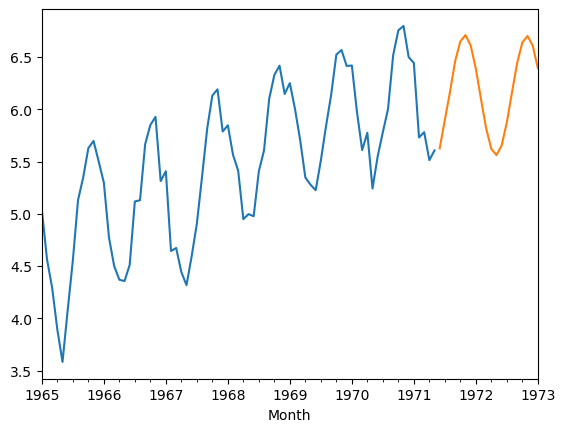

In [193]:
ts_log.plot()
ts_log2.plot()

In [147]:
# check autocorrelation
print("Durbin-Watson statistic :", sm.stats.durbin_watson(res.resid.values))

Durbin-Watson statistic : 1.2615204174493901


Usual practice is to build several models with different p and q and select
the one with smallest value of AIC, BIC, MAE and RMSE.